In [1]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

from statsmodels.formula.api import ols

In [2]:
%%bigquery audio_features
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
%%bigquery genre
SELECT * FROM snappy-boulder-378707.TrackGenre.Trackgenre

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.315,0.102,0,-17.621,0,0.0340,0.98500,0.051200,0.1090,0.1850,169.690,0Oqxt6JixieLHbwMfnJGWO,206723,3
1,0.556,0.729,0,-5.907,0,0.0432,0.03310,0.015200,0.0907,0.1520,90.003,2LRqm962By8aNwJX0WxFNG,245204,4
2,0.440,0.497,1,-6.440,0,0.0402,0.09170,0.000000,0.2150,0.2090,73.541,6bBNc3V3PduYNL22lbed5R,156892,4
3,0.648,0.874,1,-3.788,0,0.0545,0.00481,0.000023,0.0471,0.9350,138.007,14qLydrp6Uxy2kzfmv73TZ,222231,4
4,0.400,0.471,1,-12.394,0,0.1610,0.88800,0.048000,0.1150,0.0385,84.481,5ZSqX1dDJ823Dndw94nogY,67804,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74924,0.756,0.913,11,-3.486,0,0.0523,0.23400,0.000000,0.0431,0.8690,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4
74925,0.881,0.696,11,-3.838,0,0.0797,0.13700,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
74926,0.881,0.361,11,-14.728,0,0.2370,0.05020,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4
74927,0.881,0.441,11,-6.278,0,0.0646,0.48000,0.000009,0.1190,0.8040,138.014,5wfllwdjglyQislkskYLBv,221240,4


In [5]:
genre

,track_id,Alternative,Blues,Cantopop,Classical,Dance Electronic,Folk & Acoustic,Hip-Hop,Indie,Instrumental,Jazz,K-Pop,Latin,Malay Pop,Mandopop,Metal,Musik Indonesia,Pop,R&B,Rock
0,001CyR8xqmmpVZFiTZJ5BC,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,001eyxfoYptAWzvF4ewLrR,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,002LxxV7VTy5JkvkmmGanl,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,002YdWxaenIUL4PHiv5EB5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,002nFT2kRsfvS0d17AwWsB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74920,7zo6QXVQfHlycm8dsxkRGv,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74921,7zswEelYoepv2FYsDaGhUD,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74922,7zuKKxwcxaeGPrhKoNWdMP,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
74923,7zyfphPnDBks6j6uIjttMR,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [6]:
genre_unpivot = genre.melt(id_vars=['track_id'], var_name='genre', value_name='binary')
genre_unpivot = genre_unpivot[genre_unpivot["binary"]==1]
genre_unpivot

,track_id,genre,binary
10,003vvx7Niy0yvhvHt4a68B,Alternative,1
14,0085Y1oLaWiAB94I4iQo8N,Alternative,1
54,00YCRrySf0dJ6nRCKYSAkA,Alternative,1
61,00cn1ynXQhURwsgv69fN0b,Alternative,1
68,00kG2B5W9MQYdPxrICYhNg,Alternative,1
...,...,...,...
1396958,7zvUaHQrp6Pr3UG743kmP5,Rock,1
1396963,7zy7iE31dGO70ShMXghsfj,Rock,1
1402824,2hKdd3qO7cWr2Jo0Bcs0MA,Rock,1
1414789,0jWgAnTrNZmOGmqgvHhZEm,Rock,1


In [7]:
genre_unpivot = genre_unpivot.drop(['binary'],axis=1)
df = pd.merge(genre_unpivot, audio_features, how="inner", left_on="track_id", right_on="id")
df # 85637 row: higher than audio features' row - might be repetitive songs

,track_id,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,003vvx7Niy0yvhvHt4a68B,Alternative,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
1,003vvx7Niy0yvhvHt4a68B,Indie,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
2,003vvx7Niy0yvhvHt4a68B,Pop,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
3,0085Y1oLaWiAB94I4iQo8N,Alternative,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,0085Y1oLaWiAB94I4iQo8N,117500,4
4,0085Y1oLaWiAB94I4iQo8N,Indie,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,0085Y1oLaWiAB94I4iQo8N,117500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85633,7yZvWX3xZ50oh555vREpin,Rock,0.800,0.767,0,-13.148,0,0.1030,0.52000,0.333,0.3120,0.737,128.175,7yZvWX3xZ50oh555vREpin,214160,4
85634,7zKieV1uXBhucwmYM4sCzW,Rock,0.634,0.890,5,-2.618,0,0.0422,0.00719,0.000,0.3320,0.838,99.992,7zKieV1uXBhucwmYM4sCzW,210000,4
85635,7zjzu90Q4mtNNaE9Ol9Zbv,Rock,0.569,0.901,9,-5.197,1,0.0544,0.00555,0.260,0.1600,0.839,133.194,7zjzu90Q4mtNNaE9Ol9Zbv,259413,4
85636,7zrHnJ87htwgS20PzFmgTr,Rock,0.395,0.955,9,-3.799,1,0.0488,0.00962,0.000,0.3600,0.658,140.219,7zrHnJ87htwgS20PzFmgTr,199067,4


In [8]:
df["key"]=df["key"].astype('category')
df["mode"]=df["mode"].astype('category')
df["genre"]=df["genre"].astype('category')
df["time_signature"]=df["time_signature"].astype('category')

In [9]:
df = df.drop(["track_id", "id"], axis=1)
df

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Alternative,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
1,Indie,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
2,Pop,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
3,Alternative,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
4,Indie,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85633,Rock,0.800,0.767,0,-13.148,0,0.1030,0.52000,0.333,0.3120,0.737,128.175,214160,4
85634,Rock,0.634,0.890,5,-2.618,0,0.0422,0.00719,0.000,0.3320,0.838,99.992,210000,4
85635,Rock,0.569,0.901,9,-5.197,1,0.0544,0.00555,0.260,0.1600,0.839,133.194,259413,4
85636,Rock,0.395,0.955,9,-3.799,1,0.0488,0.00962,0.000,0.3600,0.658,140.219,199067,4


In [10]:
df.columns.drop(['genre'])

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [11]:
cols = df.columns.drop(['genre', 'key', 'mode', 'time_signature'])
for col in cols:
    q = df[col].quantile(0.99)
    df = df[df[col]<q]

In [12]:
df.isna().sum()

genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [13]:
df

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Alternative,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
1,Indie,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
2,Pop,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
3,Alternative,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
4,Indie,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85633,Rock,0.800,0.767,0,-13.148,0,0.1030,0.52000,0.333,0.3120,0.737,128.175,214160,4
85634,Rock,0.634,0.890,5,-2.618,0,0.0422,0.00719,0.000,0.3320,0.838,99.992,210000,4
85635,Rock,0.569,0.901,9,-5.197,1,0.0544,0.00555,0.260,0.1600,0.839,133.194,259413,4
85636,Rock,0.395,0.955,9,-3.799,1,0.0488,0.00962,0.000,0.3600,0.658,140.219,199067,4


In [14]:
df.dtypes

genre               category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms            Int64
time_signature      category
dtype: object

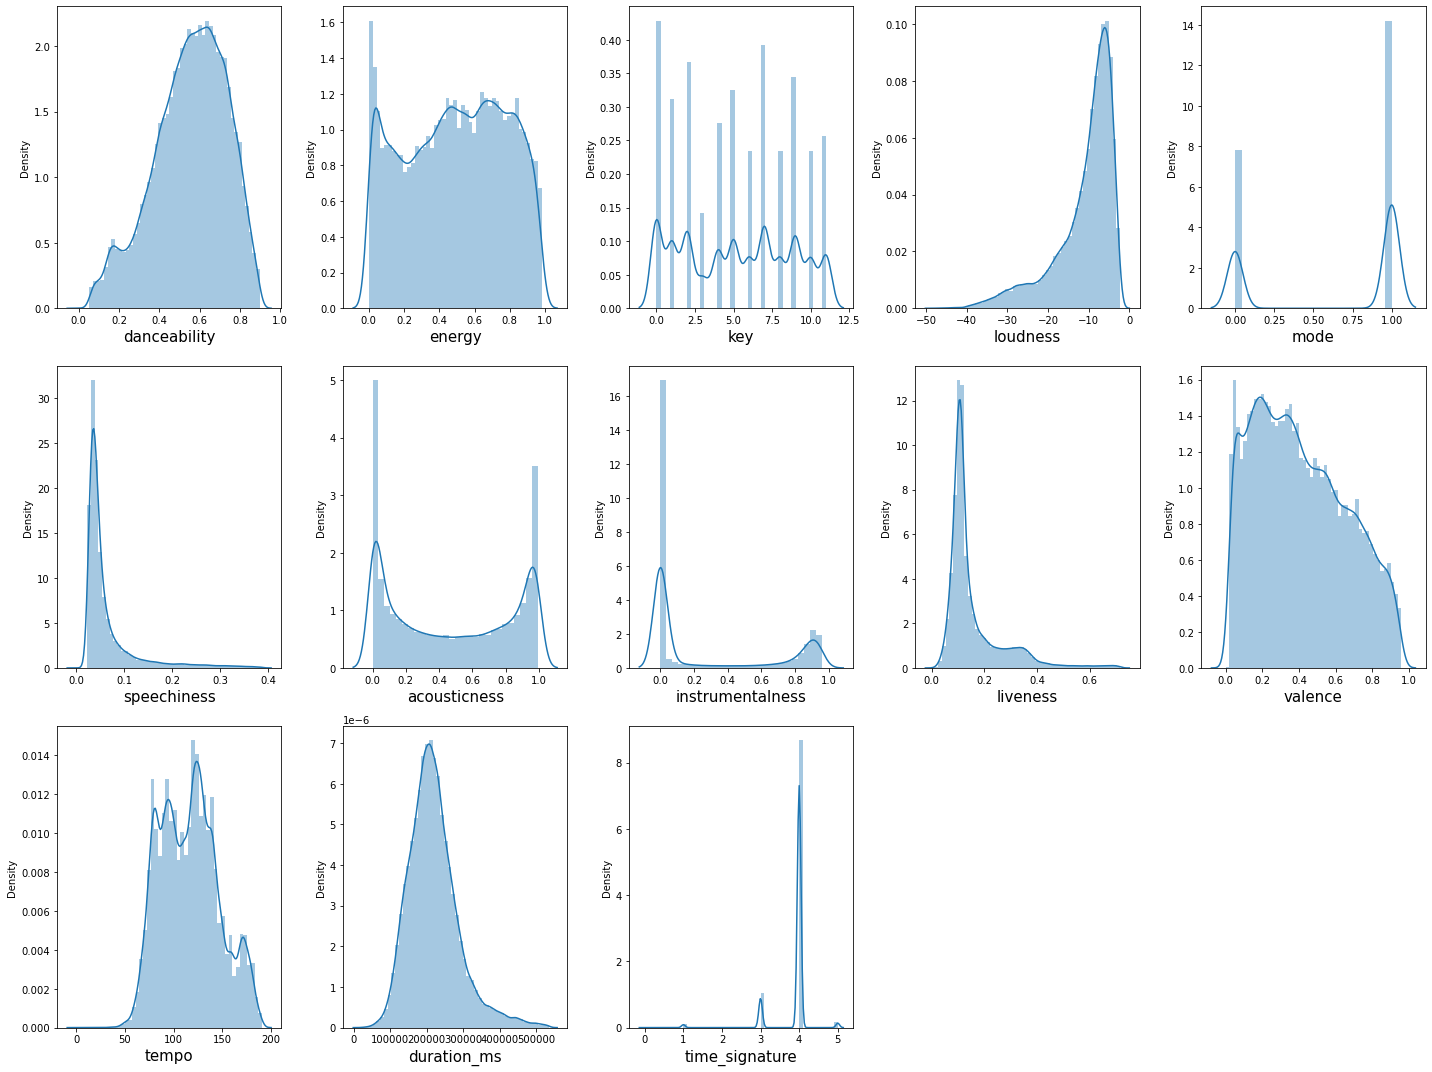

In [15]:
plt.figure(figsize = (20, 15))
plotnumber = 1
for column in df.drop(['genre'],axis=1):
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

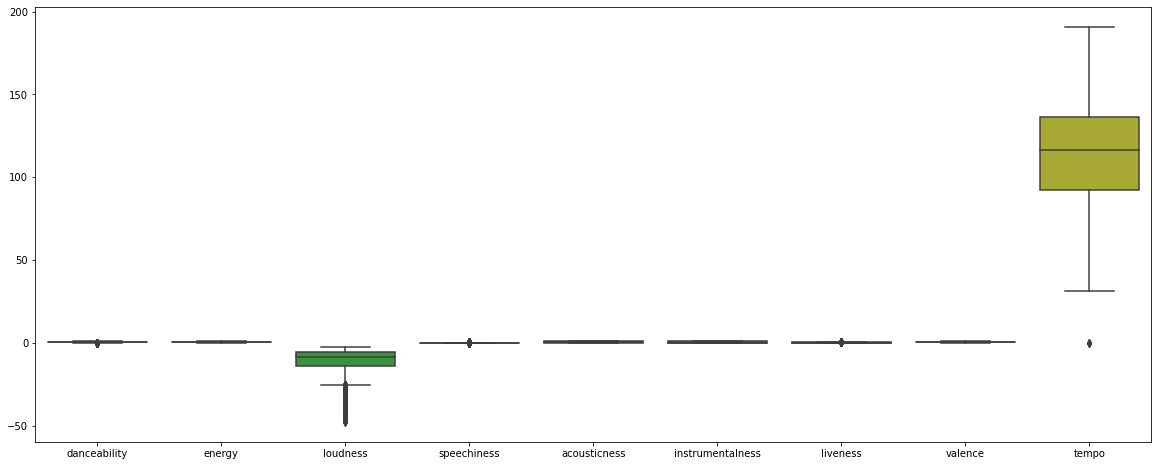

In [16]:
plt.figure(figsize = (20, 8))
sns.boxplot(data = df.drop(['duration_ms'],axis=1), width = 0.8)
plt.show()

In [17]:
from scipy.stats import norm, skew #for some statistics
cat_cols = ['genre','key','mode','time_signature']
# Find the skewed  numerical features
skew_features = df.drop(cat_cols, axis=1).apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 4 numerical features with Skew > 0.5 :


speechiness         2.858719
liveness            2.237776
duration_ms         0.995768
instrumentalness    0.816415
valence             0.340169
tempo               0.273214
acousticness        0.087626
energy             -0.106477
danceability       -0.470793
loudness           -1.520641
dtype: float64

In [18]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax
# for i in skew_index:
#     df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

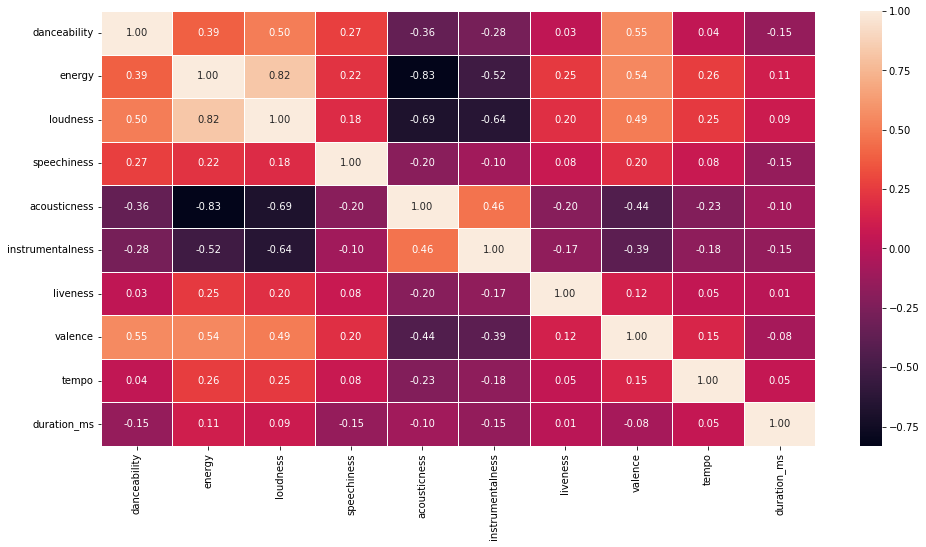

In [19]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.heatmap(df.corr(), annot = True, fmt = '1.2f', annot_kws = {'size' : 10}, linewidth = 1)
plt.show()

In [20]:
from sklearn.utils import shuffle
df = shuffle(df)

In [21]:
df = pd.get_dummies(df, columns=['key','mode','time_signature'])
df

,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
47049,Jazz,0.523,0.184,-17.063,0.0366,0.94600,0.424000,0.0677,0.0973,108.807,...,0,0,0,1,0,0,0,0,1,0
71352,Musik Indonesia,0.609,0.642,-5.495,0.0242,0.27700,0.000001,0.0939,0.2870,95.967,...,0,0,0,0,1,0,0,0,1,0
58990,K-Pop,0.590,0.676,-7.095,0.0397,0.55300,0.924000,0.0872,0.1820,123.939,...,0,0,1,1,0,0,0,0,1,0
7364,Folk & Acoustic,0.509,0.386,-8.609,0.0881,0.62400,0.000002,0.1330,0.6740,134.543,...,0,0,0,0,1,0,0,0,1,0
47250,Instrumental,0.645,0.204,-23.233,0.0361,0.61100,0.899000,0.0990,0.2660,112.009,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33592,Indie,0.662,0.481,-8.064,0.0319,0.86700,0.000120,0.0980,0.5630,120.060,...,0,0,0,1,0,0,0,0,1,0
31534,Indie,0.518,0.810,-6.445,0.0290,0.01600,0.001300,0.1150,0.1790,99.968,...,0,0,0,0,1,0,0,0,1,0
27035,Hip-Hop,0.652,0.671,-5.376,0.3150,0.00402,0.000029,0.5980,0.5180,159.963,...,0,0,0,1,0,0,0,0,1,0
1246,Alternative,0.751,0.691,-4.855,0.0697,0.19400,0.000001,0.1320,0.5110,124.971,...,0,0,0,1,0,0,0,0,1,0


In [22]:
X = df.drop(['genre','energy', 'loudness'],axis=1)
y = df[['genre']]
cols = X.columns

In [23]:
X

,danceability,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
47049,0.523,0.0366,0.94600,0.424000,0.0677,0.0973,108.807,413813,0,0,...,0,0,0,1,0,0,0,0,1,0
71352,0.609,0.0242,0.27700,0.000001,0.0939,0.2870,95.967,236707,0,0,...,0,0,0,0,1,0,0,0,1,0
58990,0.590,0.0397,0.55300,0.924000,0.0872,0.1820,123.939,131993,0,0,...,0,0,1,1,0,0,0,0,1,0
7364,0.509,0.0881,0.62400,0.000002,0.1330,0.6740,134.543,215947,0,0,...,0,0,0,0,1,0,0,0,1,0
47250,0.645,0.0361,0.61100,0.899000,0.0990,0.2660,112.009,112538,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33592,0.662,0.0319,0.86700,0.000120,0.0980,0.5630,120.060,221101,0,0,...,0,0,0,1,0,0,0,0,1,0
31534,0.518,0.0290,0.01600,0.001300,0.1150,0.1790,99.968,325547,0,0,...,0,0,0,0,1,0,0,0,1,0
27035,0.652,0.3150,0.00402,0.000029,0.5980,0.5180,159.963,208387,0,0,...,0,0,0,1,0,0,0,0,1,0
1246,0.751,0.0697,0.19400,0.000001,0.1320,0.5110,124.971,211493,0,0,...,0,0,0,1,0,0,0,0,1,0


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
sc = MinMaxScaler(feature_range = (0,100))
X = sc.fit_transform(X)

In [26]:
# checking for multicollinearity using `VIF` and `correlation matrix`
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['Features'] = cols
vif

,VIF,Features
0,1.657897,danceability
1,1.129674,speechiness
2,1.591152,acousticness
3,1.415215,instrumentalness
4,1.062423,liveness
5,1.682163,valence
6,1.084410,tempo
7,1.109805,duration_ms
8,inf,key_0
9,inf,key_1


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_st = pd.DataFrame(X_train, columns=[cols])
X_test_st = pd.DataFrame(X_test, columns=[cols])

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc=SVC() 
svc.fit(X_train_st,y_train)
y_pred=svc.predict(X_test_st)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.model_selection import cross_validate,GridSearchCV
xgb = XGBClassifier()
# params={"n_estimators":[67,70,100,120],'reg_lambda':[2,1],'gamma':[0,0.3,0.2,0.1]
#        ,'eta':[0.06,0.05,0.04]
#         ,"max_depth":[5,6,7],'objective':['binary:logistic']}
# clf=GridSearchCV(reg,params,cv=10,n_jobs=-1,verbose=1)
# clf.fit(X_train,y_train)
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)
# y_pred = clf.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

[10:35:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model accuracy score with default hyperparameters: 0.4200


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.2862


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.3938


In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

TypeError: predict() got an unexpected keyword argument 'validation_split'

In [32]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix , accuracy_score
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=8)
# fit the model to the training set
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.3350


In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV
# knn = KNeighborsClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# space = dict()
# space['n_neighbors'] = [3,5,8]
# space['weights'] = ['uniform', 'distance']
# # space['C'] = loguniform(1e-5, 100)
# search = RandomizedSearchCV(knn, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# result = search.fit(X_train, y_train)
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [36]:
# unknown model
# https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

rf.fit(X_train, y_train)

# make a prediction on the test set
y_pred = model.predict(X_test)
# calculate accuracy
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

480/480 [==============================] - 1s 997us/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [28]:
output_num = len(df['genre'].unique())
output_num

19

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

regressor = Sequential()

size = 200
regressor.add(LSTM(units = size,return_sequences = True,activation="relu",input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = size//2,return_sequences = True, activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = size//4,return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = size//8))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = output_num))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
# regressor.fit(X_train,pd.get_dummies(y_train['genre']),epochs = 35, batch_size = 100, validation_data=(X_val, y_val))
regressor.fit(X_train,pd.get_dummies(y_train['genre']),epochs = 35, batch_size = 100)
y_pred = regressor.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, np.argmax(y_pred, axis=1))))

Epoch 1/35
615/615 [==============================] - 261s 395ms/step - loss: 0.0526 - accuracy: 0.1650
Epoch 2/35
615/615 [==============================] - 261s 425ms/step - loss: 0.0486 - accuracy: 0.1928
Epoch 3/35
615/615 [==============================] - 13217s 22s/step - loss: 0.0485 - accuracy: 0.1930
Epoch 4/35
615/615 [==============================] - 198s 321ms/step - loss: 0.0484 - accuracy: 0.1930
Epoch 5/35
615/615 [==============================] - 247s 402ms/step - loss: 0.0484 - accuracy: 0.1929
Epoch 6/35
615/615 [==============================] - 275s 448ms/step - loss: 0.0484 - accuracy: 0.1929
Epoch 7/35
615/615 [==============================] - 965s 2s/step - loss: 0.0484 - accuracy: 0.1929
Epoch 8/35
615/615 [==============================] - 279s 453ms/step - loss: 0.0483 - accuracy: 0.1958
Epoch 9/35
615/615 [==============================] - 297s 484ms/step - loss: 0.0456 - accuracy: 0.2486
Epoch 10/35
615/615 [==============================] - 294s 478ms/s

NameError: name 'accuracy_score' is not defined

In [70]:
y_pred = regressor.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, np.argmax(y_pred, axis=1))))

480/480 [==============================] - 35s 68ms/step
Model accuracy score with default hyperparameters: 0.2855


In [106]:
y_train['genre'].replace(['Instrumental', 'K-Pop', 'Folk & Acoustic', 'Latin', 'Indie', 'Classical',
                             'Mandopop', 'Jazz', 'Dance Electronic', 'Blues', 'Rock', 'Cantopop',
                             'Hip-Hop', 'Musik Indonesia', 'R&B', 'Alternative', 'Metal', 'Pop', 'Malay Pop'],
                        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], inplace=True)
y_train

,genre
65440,10
47259,7
43755,7
48169,0
45725,0
...,...
71964,18
8225,9
70671,10
47571,0


In [107]:
y_test['genre'].replace(['Instrumental', 'K-Pop', 'Folk & Acoustic', 'Latin', 'Indie', 'Classical',
                             'Mandopop', 'Jazz', 'Dance Electronic', 'Blues', 'Rock', 'Cantopop',
                             'Hip-Hop', 'Musik Indonesia', 'R&B', 'Alternative', 'Metal', 'Pop', 'Malay Pop'],
                        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], inplace=True)
y_test

,genre
81028,13
63465,1
61120,1
26721,2
79071,16
...,...
31791,4
34357,14
65382,3
44696,0


In [60]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers.core import Dropout
from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling1D

lsize = 128

model = Sequential()
model.add(Dense(lsize, input_dim=int(X_train.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))
# class的数量

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()
# 试一下其他optimizer

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=1026, 
                    validation_split=0.2, verbose=1)

y_pred = model.predict(X_test)
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, np.argmax(y_pred, axis=1))))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               3584      
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_17 (Dropout)        (None, 64)               

In [36]:
# decision tree,random forest,gradient boost,rnn,Knn
# then use ensemble learning - stacking, boosting

In [37]:
# oversample or subsample 让每个genre的数量差不多
# minmaxsclaer, robustscaler

In [ ]:
# accuracy用max测
# get top 3 or above threshold into big query

In [38]:
# ids = pd.read_csv("ids 2019.csv")
# artists = pd.read_csv("artist2019.csv")

## duplicate rows 

In [39]:
# df = df.drop(['Unnamed: 0', 'track_id', 'id_x', 'name', 'followers', 'id_y', 'duration_ms', 'time_signature'], axis=1)

In [40]:
# newdf = pd.DataFrame(columns=df.columns)
# newdf

In [41]:
# for i in range(0, df.shape[0]): # running time: - 19
#     row = df.iloc[i]
#     genres = row[0].strip('][').split(', ')
#     # genres = row[0]
#     others = row[1:]
#     # new_row = pd.Series(genres[0]).append(others)
#     for genre in genres:
#         new_row = pd.Series(genre, index = ['genres']).append(others)
#         newdf = newdf.append(new_row, ignore_index=True)

In [42]:
# len(newdf['genres'].value_counts())

In [43]:
# newdf

In [44]:
# from sklearn.utils import shuffle
# newdf_sh = shuffle(newdf)

In [45]:
# from sklearn.model_selection import train_test_split
# new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(newdf_sh.drop("genres",axis=1), newdf_sh["genres"], test_size=0.2, random_state=42)

In [46]:
# cols = new_X_train.columns

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# new_X_train_st = scaler.fit_transform(new_X_train)
# new_X_test_st = scaler.transform(new_X_test)

# new_X_train_st = pd.DataFrame(new_X_train_st, columns=[cols])
# new_X_test_st = pd.DataFrame(new_X_test_st, columns=[cols])

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# svc=SVC() 
# svc.fit(new_X_train_st,new_y_train)
# new_y_pred=svc.predict(new_X_test_st)
# print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(new_y_test, new_y_pred)))

https://www.kaggle.com/code/arthurlees/spotify-song-attribute-analysis

In [47]:
# tracks = pd.read_excel("spotify_genre_final.xlsx")
# tracks.head()

In [48]:
# tracks.shape

In [49]:
# audio_feature.shape

In [50]:
# df = pd.merge(tracks, audio_feature, on="id", how="inner")
# df.shape

In [51]:
# tracks["Genre"].value_counts()

In [52]:
# from sklearn.utils import shuffle
# tracks = shuffle(tracks)
# tracks.head()

In [53]:
# tracks.columns

In [54]:
# df = df.drop(['Title', 'Album_cover_link', 'Artist', 'id', 'popularity', 'release_date',
#               'release_date_precision', 'total_tracks', 'int64_field_0', 'type', 'uri', 'track_href',
#               'analysis_url','uri', 'track_href', 'analysis_url'], axis = 1)
# tracks = tracks.drop(['Title', 'Album_cover_link', 'Artist', 'id', 'release_date', 
#               'release_date_precision', 'total_tracks', 'time_signature'],axis=1)
# tracks

In [55]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(tracks.drop("Genre",axis=1), tracks["Genre"], test_size=0.2, random_state=42)

In [56]:
# X_train.shape

In [57]:
# X_test.shape

In [58]:
# y_train.shape

In [59]:
# cols = X_train.columns

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_st = scaler.fit_transform(X_train)
# X_test_st = scaler.transform(X_test)

# X_train_st = pd.DataFrame(X_train_st, columns=[cols])
# X_test_st = pd.DataFrame(X_test_st, columns=[cols])

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# svc=SVC() 
# svc.fit(X_train_st,y_train)
# y_pred=svc.predict(X_test_st)
# print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
# # 0.5845